In [ ]:
#reference 
'''
https://github.com/AntixK/PyTorch-VAE
Dataset - https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

'''

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 

In [40]:
#encoder
#conv_output = input - filter(kernel) + 2*pad / stride + 1
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)   # Output: 32 x 128 x 128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: 64 x 64 x 64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # Output: 128 x 32 x 32
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) # Output: 256 x 16 x 16
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1) # Output: 512 x 8 x 8
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)
        self.fc21 = nn.Linear(1024, latent_dim)  # Mean
        self.fc22 = nn.Linear(1024, latent_dim)  # Log variance

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        mu = self.fc21(x)
        logvar = self.fc22(x)
        return mu, logvar

'''
Why Do We Need Reparameterization?
sampling directly from a Gaussian distribution using mu and logvar would involve a stochastic process, 
which makes it challenging to compute gradients for backpropagation during training. This is where the 
reparameterization trick comes in.

The reparameterization trick allows us to express the sampling process in a way that enables 
gradient computation.

z = mu + logvar*epsilon , epsilon is from standard normal distribution(mean = 0, sd = 1)
By doing this, we can rewrite the sampling process as a deterministic function which is indepdent of 
learned parameteres, This allows the gradient to flow through mu and logvar during backpropagation.

'''

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [73]:
from pathlib import Path
from typing import List, Optional, Sequence, Union, Any, Callable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import Subset

from torchvision.datasets import CelebA

class MyCelebA(CelebA):    
    def _check_integrity(self) -> bool:
        return True

class VAEDataset(Dataset):
    def __init__(
        self,
        data_path: str = 'celeba',
        train_batch_size: int = 8,
        val_batch_size: int = 8,
        patch_size: Union[int, Sequence[int]] = (256, 256), # the size of the crop to take from the original images.
        num_workers: int = 0,
        pin_memory: bool = False, # whether prepared items should be loaded into pinned memory or not. This can improve performance on GPUs.
        **kwargs,):
        
        super().__init__()

        self.data_dir = data_path
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.patch_size = patch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        
    def setup(self, stage: Optional[str] = None) -> None:
        train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.CenterCrop(148),
                                              transforms.Resize(self.patch_size),
                                              transforms.ToTensor(),])
        
        val_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.CenterCrop(148),
                                            transforms.Resize(self.patch_size),
                                            transforms.ToTensor(),])
        
        self.train_dataset = MyCelebA(
            self.data_dir,
            split='train',
            transform=train_transforms,
            download=False,
        )
        
        self.train_dataset = Subset(self.train_dataset, range(1000))
        
        # Replace CelebA with your dataset
        self.val_dataset = MyCelebA(
            self.data_dir,
            split='test',
            transform=val_transforms,
            download=False,
        )
        
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=self.pin_memory,
        )
    
    def test_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=144,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

In [74]:
vae_data = VAEDataset()
vae_data.setup()
train_data = vae_data.train_dataloader()

In [75]:
dataiter = iter(train_data)
image, label = next(dataiter)

In [76]:
image.shape #batch, channels(RGB), dim, dim

torch.Size([8, 3, 256, 256])

In [77]:
image

tensor([[[[0.6941, 0.6902, 0.6863,  ..., 0.9059, 0.9059, 0.9059],
          [0.6941, 0.6902, 0.6863,  ..., 0.9059, 0.9059, 0.9059],
          [0.6902, 0.6902, 0.6863,  ..., 0.9059, 0.9059, 0.9059],
          ...,
          [0.9529, 0.9490, 0.9451,  ..., 0.1725, 0.2157, 0.2431],
          [0.9490, 0.9451, 0.9373,  ..., 0.1686, 0.2118, 0.2392],
          [0.9490, 0.9451, 0.9333,  ..., 0.1686, 0.2118, 0.2392]],

         [[0.8157, 0.8275, 0.8431,  ..., 0.9059, 0.9059, 0.9059],
          [0.8157, 0.8275, 0.8431,  ..., 0.9059, 0.9059, 0.9059],
          [0.8157, 0.8275, 0.8431,  ..., 0.9059, 0.9059, 0.9059],
          ...,
          [0.9451, 0.9490, 0.9529,  ..., 0.1137, 0.1451, 0.1686],
          [0.9412, 0.9451, 0.9529,  ..., 0.1098, 0.1412, 0.1647],
          [0.9412, 0.9451, 0.9529,  ..., 0.1098, 0.1412, 0.1647]],

         [[0.9255, 0.9294, 0.9412,  ..., 0.9059, 0.9059, 0.9059],
          [0.9216, 0.9294, 0.9412,  ..., 0.9059, 0.9059, 0.9059],
          [0.9137, 0.9255, 0.9412,  ..., 0

In [78]:
latent_dim = 128 
encoder = Encoder(latent_dim)

def encode_and_sample(encoder, x):
    mu, logvar = encoder(x)
    z = reparameterize(mu, logvar)
    return z, mu, logvar

z, mu, logvar = encode_and_sample(encoder, image)

print(f"Encoded latent vector shape: {z.shape}")
print(f"Mean vector shape: {mu.shape}")
print(f"Log variance vector shape: {logvar.shape}")

Encoded latent vector shape: torch.Size([8, 128])
Mean vector shape: torch.Size([8, 128])
Log variance vector shape: torch.Size([8, 128])


## Decoder

In [79]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc3 = nn.Linear(latent_dim, 512 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)  # Output: 256 x 16 x 16
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # Output: 128 x 32 x 32
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # Output: 64 x 64 x 64
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)    # Output: 32 x 128 x 128
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)     # Output: 3 x 256 x 256

    def forward(self, z):
        x = torch.relu(self.fc3(z))
        x = x.view(z.size(0), 512, 8, 8)  # Reshape to 512 x 8 x 8
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.relu(self.deconv3(x))
        x = torch.relu(self.deconv4(x))
        x = torch.sigmoid(self.deconv5(x))  # Output pixel values between 0 and 1
        return x


In [80]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


In [81]:
def loss_function(recon_x, x, mu, logvar):
    # BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum') # single scalar value that represents the total reconstruction error for batch
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [90]:
latent_dim = 128
epochs = 20
learning_rate = 1e-3

vae = VAE(latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [91]:
len(train_data)

125

In [92]:
from tqdm import tqdm

for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_data)):
        data = data
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

125it [00:56,  2.23it/s]


Epoch 1, Loss: 82.5711


125it [00:58,  2.15it/s]


Epoch 2, Loss: 43.5580


125it [01:01,  2.02it/s]


Epoch 3, Loss: 37.3784


125it [01:07,  1.84it/s]


Epoch 4, Loss: 34.5562


125it [01:11,  1.75it/s]


Epoch 5, Loss: 32.2287


125it [01:22,  1.52it/s]


Epoch 6, Loss: 30.5958


125it [01:22,  1.52it/s]


Epoch 7, Loss: 29.7372


125it [01:11,  1.75it/s]


Epoch 8, Loss: 28.7367


125it [01:19,  1.58it/s]


Epoch 9, Loss: 27.4766


125it [01:19,  1.57it/s]


Epoch 10, Loss: 26.3429


125it [01:13,  1.69it/s]


Epoch 11, Loss: 25.8112


125it [01:13,  1.70it/s]


Epoch 12, Loss: 25.1061


125it [01:12,  1.73it/s]


Epoch 13, Loss: 24.2917


125it [01:14,  1.68it/s]


Epoch 14, Loss: 24.0820


125it [01:04,  1.94it/s]


Epoch 15, Loss: 23.3625


125it [01:04,  1.92it/s]


Epoch 16, Loss: 22.7635


125it [00:54,  2.29it/s]


Epoch 17, Loss: 22.4378


125it [00:54,  2.30it/s]


Epoch 18, Loss: 21.7824


125it [01:00,  2.07it/s]


Epoch 19, Loss: 21.1235


125it [01:08,  1.84it/s]

Epoch 20, Loss: 21.0341


In [85]:
import matplotlib.pyplot as plt

def show_images(original, reconstructed, n=8):
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().detach().numpy())
        axes[1, i].axis('off')
    plt.show()
    
    

vae.eval()
dataiter = iter(train_data)
image, label = next(dataiter)

reconstructed, _, _ = vae(image)

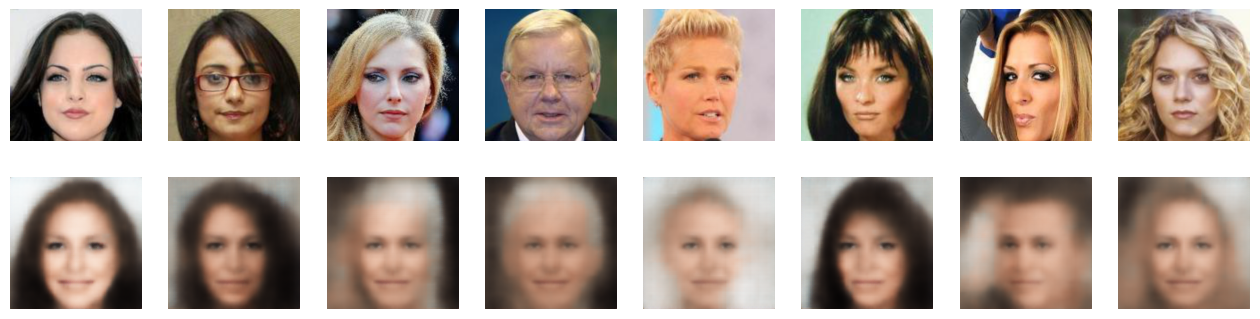

In [86]:
show_images(image, reconstructed)

In [ ]:
import matplotlib.pyplot as plt

def show_images(original, reconstructed, n=8):
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().detach().numpy())
        axes[1, i].axis('off')
    plt.show()
    
    

vae.eval()
dataiter = iter(train_data)
image, label = next(dataiter)

reconstructed, _, _ = vae(image)